# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

**Задача:**
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.


## Загрузка данных

In [1]:
#Загружаем библиотеки
import pandas as pd
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')  

In [2]:
#Загружаем данные 
data = pd.read_csv('/datasets/gym_churn.csv', sep=',')

#Проводим первичную диагностику данных
data.columns=data.columns.str.lower() #сразу приведем названия столбцов к нижнему регистру
display(data.head(10))
print(data.info())
print(data.shape)
print("Таблица содержит {:.0f} дубликатов".format(data.duplicated().sum()))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

**Вывод** :
Таблица с исходными данными имеет 4000 строк, не имеет пропусков и дубликатов. 

*Спецификация данных:*
- 'churn' - факт оттока в текущем месяце (целевая переменная)
- 'gender' - пол
- 'near_location' - проживание или работа в районе, где находится фитнес-центр
- 'partner' - сотрудник компании-партёра клуба
- 'promo_friends' - факт первоначальной записи в рамках акции "приведи друга"
- 'phone' - наличие контактного телефона
- 'age' - возраст
- 'lifetime' - время с первого обращения в фитнесс-центр
- 'contract_period' - длительность текущего действующего аобнемента (месяц, 3 месяца, 6 месяцев, 1 год)
- 'month_to_end_contract' - срок до окончания текущего действующего абонемента (в месяцах)
- 'group_visits' - факт посещения групповых занятий
- 'avg_class_frequency_total' - средняя частота посещений в неделю за все время с начала действия абонемента
- 'avg_class_frequency_current_month' - средняя частота посещений в неделю за предыдущий месяц
- 'avg_additional_charges_total' - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
Названия колонок были приведены к нижнему регистру для удобства последующего анализа.

## Исследовательский анализ данных 

### Изучение датасета: средние значения и стандартные отклонения, наличие отсутствующих признаков 

In [3]:
# Вызовем метод describe для изучения данных 
print(data.describe().T)

                                    count        mean        std        min        25%         50%         75%         max
gender                             4000.0    0.510250   0.499957   0.000000   0.000000    1.000000    1.000000    1.000000
near_location                      4000.0    0.845250   0.361711   0.000000   1.000000    1.000000    1.000000    1.000000
partner                            4000.0    0.486750   0.499887   0.000000   0.000000    0.000000    1.000000    1.000000
promo_friends                      4000.0    0.308500   0.461932   0.000000   0.000000    0.000000    1.000000    1.000000
phone                              4000.0    0.903500   0.295313   0.000000   1.000000    1.000000    1.000000    1.000000
contract_period                    4000.0    4.681250   4.549706   1.000000   1.000000    1.000000    6.000000   12.000000
group_visits                       4000.0    0.412250   0.492301   0.000000   0.000000    0.000000    1.000000    1.000000
age             

**Вывод**:
В исходных данных не было обнаружено вызывающих подозрение или выпадающих значений. По предварительным данным можно сделать вывод, что клиенты клуба - люди в возрасте от 18 лет до 41 года (средний возраст клиента - 29 лет), распределение по полу примерно одинаковое, суммарная выручка от других услуг клуба колеблется от 0,14 до 552,60 и имеет среднее арифметическое значение равное 146,9, частота посещения зала в неделю колеблется от 0 до 6 раз и имеет средне арифметическое значение - около 2 (1,9).
Большинство клиентов (85%) живет или работает рядом с фитнес-клубом, примерно половина клиентов являются сотрудниками партнерских организаций, около 30% клиентов пришли по программе "Приведи друга", также известны мобильные номера примерно 90% клиентов.

### Исследование средних значений признаков в двух группах — тех, кто ушел в отток и тех, кто остался 

In [4]:
#Разделим данные на 2 группы по признаку оттока (churn)
data_churn_group=data.groupby(['churn']).mean()
pd.set_option('display.max_columns', None)
data_churn_group.columns=[x.replace('_',' ') for x in data_churn_group.columns]
data_churn_group.style.set_table_styles([dict(selector='th',props=[{'max-width','50px'}])])

,gender,near location,partner,promo friends,phone,contract period,group visits,age,avg additional charges total,month to end contract,lifetime,avg class frequency total,avg class frequency current month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


По данным можно сделать вывод, что те клиенты, кто остался (churn = 0) чаще являются сотрудниками компании-партнёра клуба, приходят в клуб по акции "приведи друга", имеют абонемент, в среднем, на 5,7 месяцев (те, кто оттошел от занятий имеют абонемент в среднем на 1,7 месяца), посещают групповые занятия, приносят больше суммарной выручки от других услуг фитнес-центра, и посещают занятия, в среднем, 2 раза в неделю. Остаются чаще люди более старшего возраста: средний возраст оставшихся - почти 30 лет, а средний возраст ушедших - почти 27 лет. Можно сделать вывод, что те, кто остаются клиентами клуба дольше месяца - становятся постоянными клиентами, т.к. среднее время с момента первого обращения в фитнес-центр для оставшихся клиентов составляет 4,7месяца, а для уходящих клиентов - чуть меньше 1 месяца.

### Построение столбчатых гистограмм и распределение признаков для тех, кто ушел и тех, кто остался.

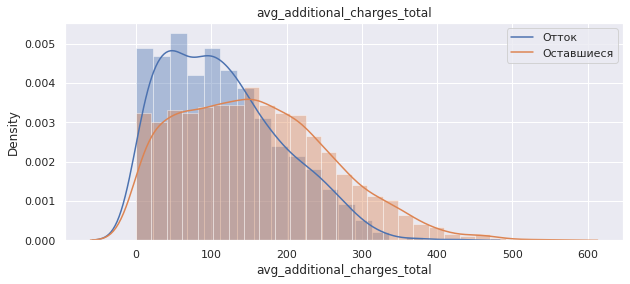

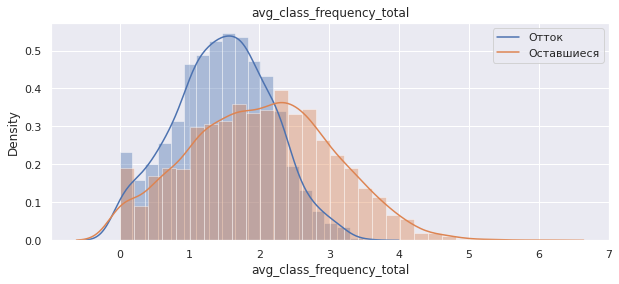

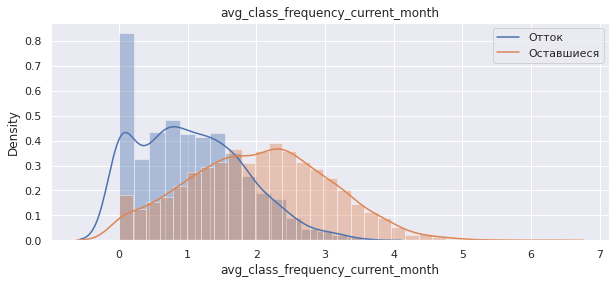

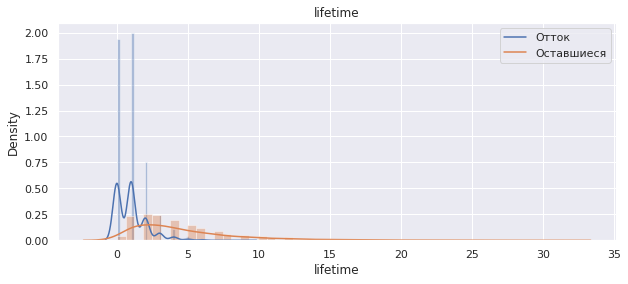

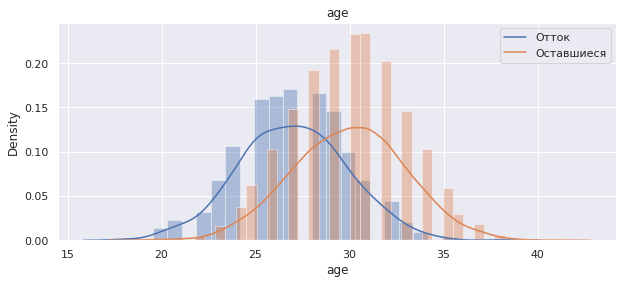

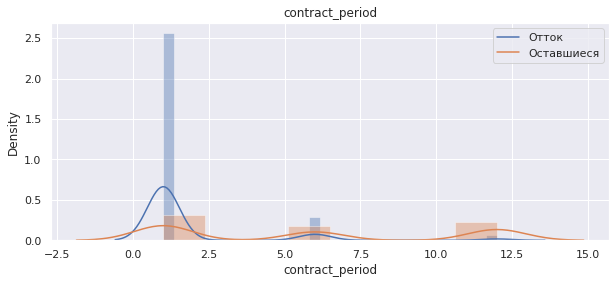

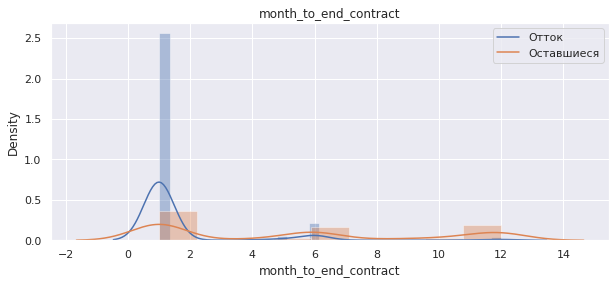

In [5]:
left = data[data['churn']==1]
stayed = data[data['churn']==0]
distplot_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']
for column in distplot_columns: 
    plt.figure(figsize=(10,4)) 
    plt.title(column)
    sns.distplot(left[column])
    sns.distplot(stayed[column])
    plt.legend(['Отток', 'Оставшиеся'])
    plt.show()

**Вывод**:
Гистограммы показывают, что чаще уходят молодые люди (от 20 до 26 лет), время с момента первого обращения которых в фитнес-центр составляет 1-2 месяца, с абонементом на 1 месяц. Суммарная выручка от других услуг фитнес-центра на долю ушедших относительно доли постоянных клиетов невелика.

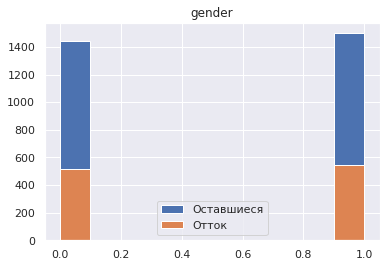

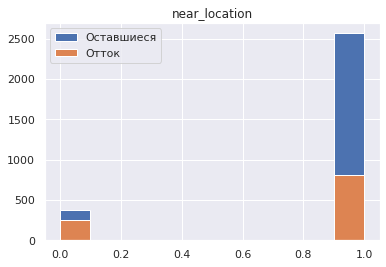

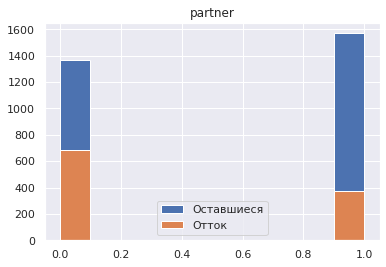

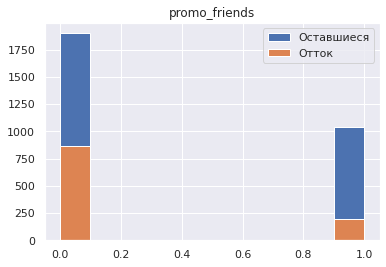

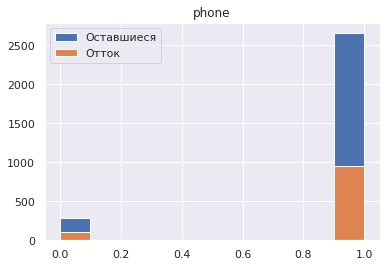

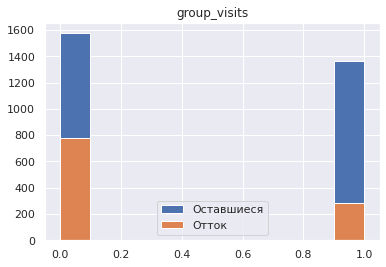

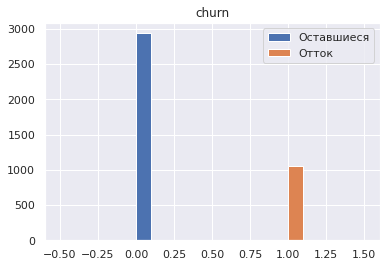

In [6]:
for column in data.columns:
    if column not in distplot_columns:
        data.groupby('churn')[column].hist()
        plt.title(column)
        plt.legend(['Оставшиеся', 'Отток'])
        plt.show()


**Вывод**:
Графики показывают, что чаще остаются клиенты, которые живут или работают неподалеку, приходящие по акции "приведи друга" и посещающие групповые занятия. От пола клиента отток не зависит, другими словами, распределение равномерное.

### Матрица корреляций

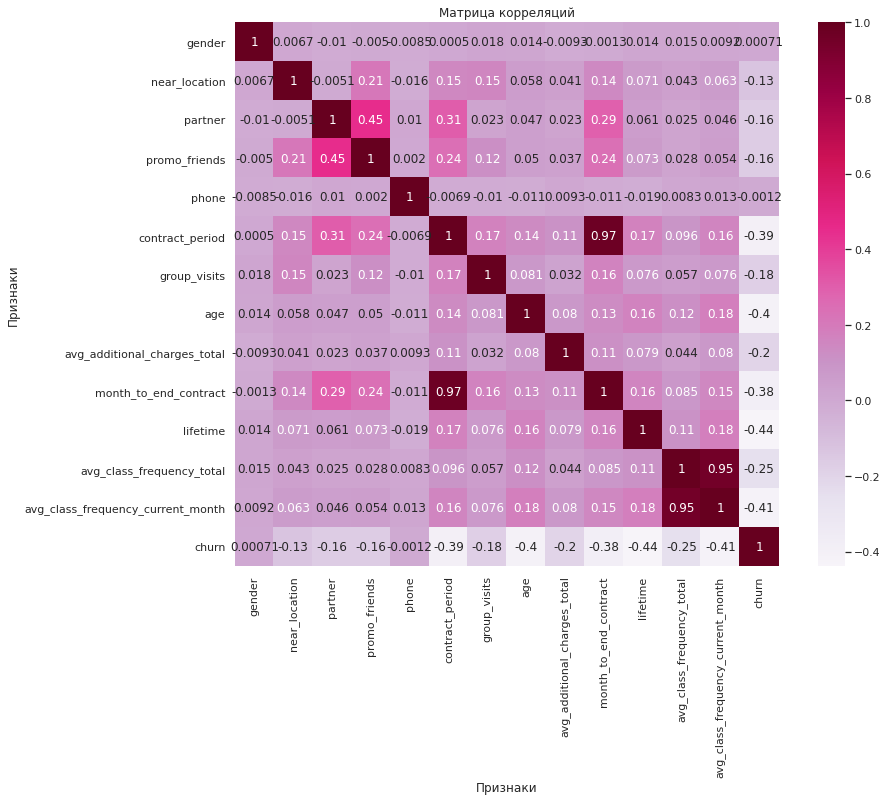

In [7]:
plt.figure(figsize=(14,10))
sns.heatmap(data = data.corr(), annot=True, square=True, cmap='PuRd')
plt.title('Матрица корреляций')
plt.xlabel("Признаки")
plt.ylabel("Признаки")
plt.show()

**Вывод**:
Матрица корреляций показывает сильную связь между столбцами "средняя частота посещений в неделю за все время с начала действия абонемента" и "средняя частота посещений в неделю за предыдущий месяц", что говорит о стабильности посещений(или прогулов) тренировок клиентами. Так же можно видеть связь между признаками "сотрудник организации-партнера" и участник акции "приведи друга", что логично, т.к. зная о возможных привелегиях для сотрудников какой-либо организации будущие клиенты чаще пользуются акциями "приведи друга" и приходят познакомиться с клубом с коллегами, которые уже являются клиентами.

## Построение модели прогнозирования оттока пользователей

In [8]:
import warnings
warnings.filterwarnings('ignore')
#выделение данных
y = data['churn']
X = data.drop(['churn'], axis = 1)
#деление данных на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#стандартизация выборок
scaler=StandardScaler()
X_train_st=scaler.fit_transform(X_train)
X_test_st=scaler.transform(X_test)
#обучение моделей
model_lr = LogisticRegression(random_state=0)
model_rf=RandomForestClassifier(n_estimators=100, random_state=0)
model_lr.fit(X_train_st,y_train)
model_rf.fit(X_train_st,y_train)

RandomForestClassifier(random_state=0)

In [9]:
#Код ревьюера

print(X_train.shape, X_test.shape)

(3200, 13) (800, 13)


In [10]:
#модель логистической регрессии
y_pred=model_lr.predict(X_test_st)
accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test, y_pred)
print("Доля правильных ответов",accuracy)
print("Точность", precision)
print("Полнота", recall)

Доля правильных ответов 0.9225
Точность 0.8541666666666666
Полнота 0.8282828282828283


**Вывод**:

Доля правильных прогнозов и полнота чуть выше в модели логистической регрессии, соответственно, модель логистической регрессии показала себя лучше.

## Кластеризация пользователей

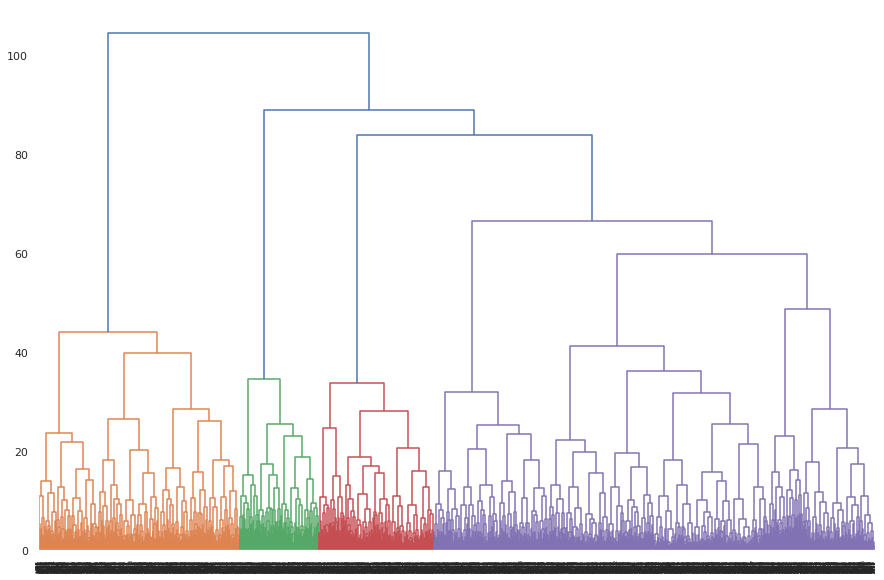

In [11]:
# Проведем кластеризацию пользователей без столбца целевого значения

X_st = scaler.fit_transform(X)#стандартизация данных
#построение матрицы расстояний и дендрограммы
linked=linkage(X_st, method='ward')
plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.show()

### Изучение средних значений признаков для кластеров

In [12]:
#список количественных переменных
list1=['age', 'lifetime', 'contract_period', 'avg_additional_charges_total', 'month_to_end_contract', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
#список категориальных пременных
list2=['gender','near_location', 'partner', 'promo_friends','phone', 'group_visits']
#задаем модель k_means с числом кластеров 5
km=KMeans(n_clusters=5)
#прогнозируем кластеры для наблюдений
labels=km.fit_predict(X_st)
#сохраняем метки кластера в поле датасета
data['cluster']=labels
#вывод статистики по средним значениям признаков по кластеру
data.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.485306,1.000000,0.351072,0.239873,1.000000,1.950755,0.339952,28.169182,131.802126,1.858618,2.428118,1.246128,1.010956,0.515488
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.374257,0.217822,28.465347,135.224414,2.219802,2.809901,1.656137,1.472887,0.443564
3,0.561237,0.975030,0.353151,0.228300,0.998811,2.657551,0.475624,30.129608,161.410279,2.448276,4.920333,2.846236,2.844141,0.067776
4,0.501980,0.960396,0.785149,0.576238,1.000000,10.883168,0.541584,29.977228,160.770258,9.948515,4.726733,1.986130,1.979091,0.027723


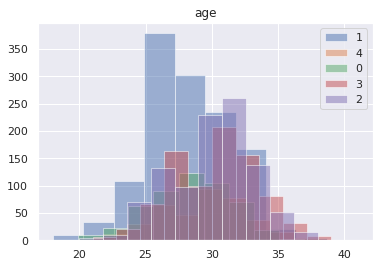

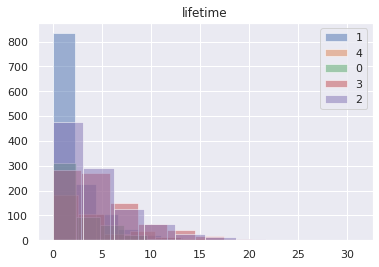

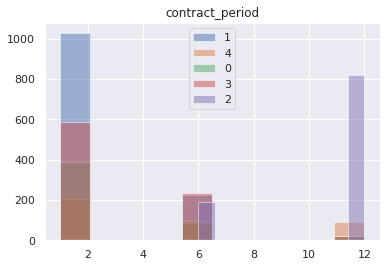

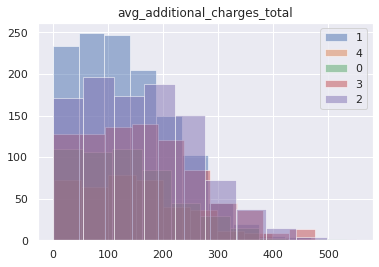

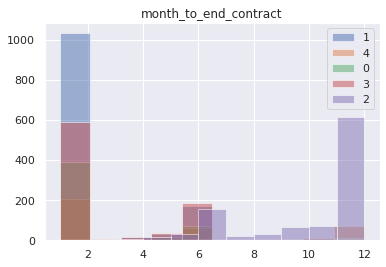

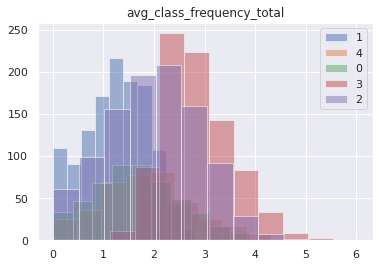

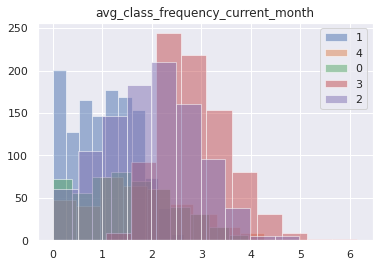

In [13]:
for i in list1:
    data.groupby('cluster')[i].hist(alpha=0.5)
    plt.legend(data['cluster'].unique())
    plt.title(i)
    plt.show()

**Вывод**:
Исходя из полученных гистограмм можно сформулировать характеристики кластеров: 
- в 4 кластер  входят люди от 18 до 28 лет, чаще оформляли абонемент на 1 месяц, посещают занятия 1-2 раза в неделю, в среднем за последний месяц посещали занятия 1 раз в неделю и реже.
- в 3 кластер входят люди от 28 до 33 лет, чаще оформляли абонемент на 6 месяцев, посещают занятия до 2 раз в неделю, в среднем за последний месяц посещали занятия до 2 раз в неделю
- во 2 кластер входят люди от 27 до 34 лет, посещают занятия от 2 до 4 раз в неделю, в среднем за последний месяц посещали занятия более 2 раз в неделю
- в 1 кластер входят люди от 27 до 32 лет, посещают занятия 2-3 раза в неделю, в среднем за последний месяц посещали занятия 1-2 раза в неделю
- в 0 кластер входят люди от 28 до 33 лет, чаще оформляли абонементы на 12 месяцев, посещают занятия 1-3 раза в неделю, в среднем за последний месяц посещали занятия 1-3 раза в неделю.


### Построение распределения признаков для кластеров

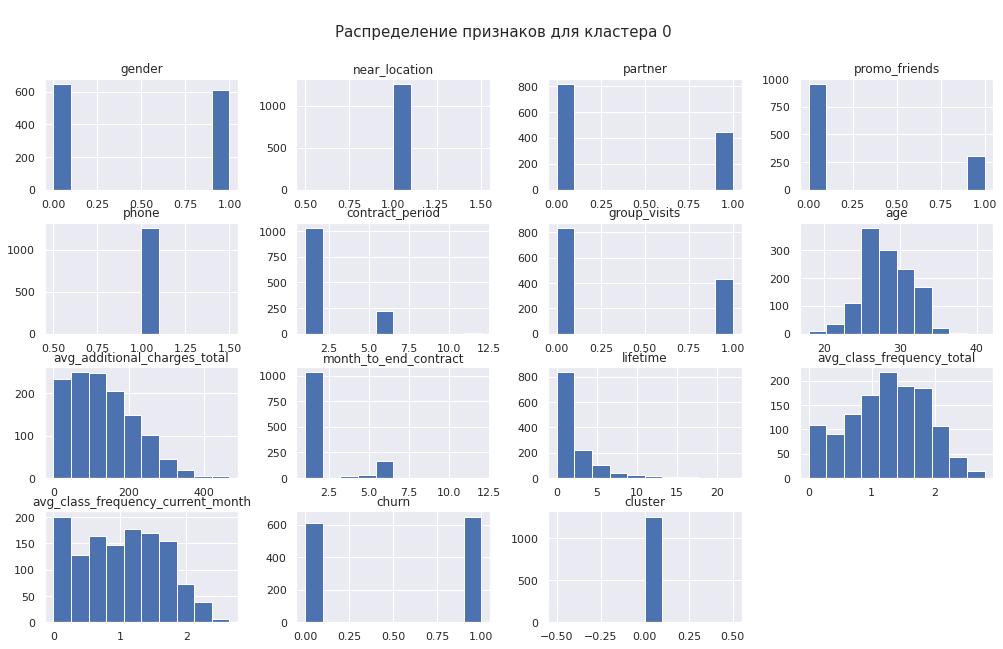

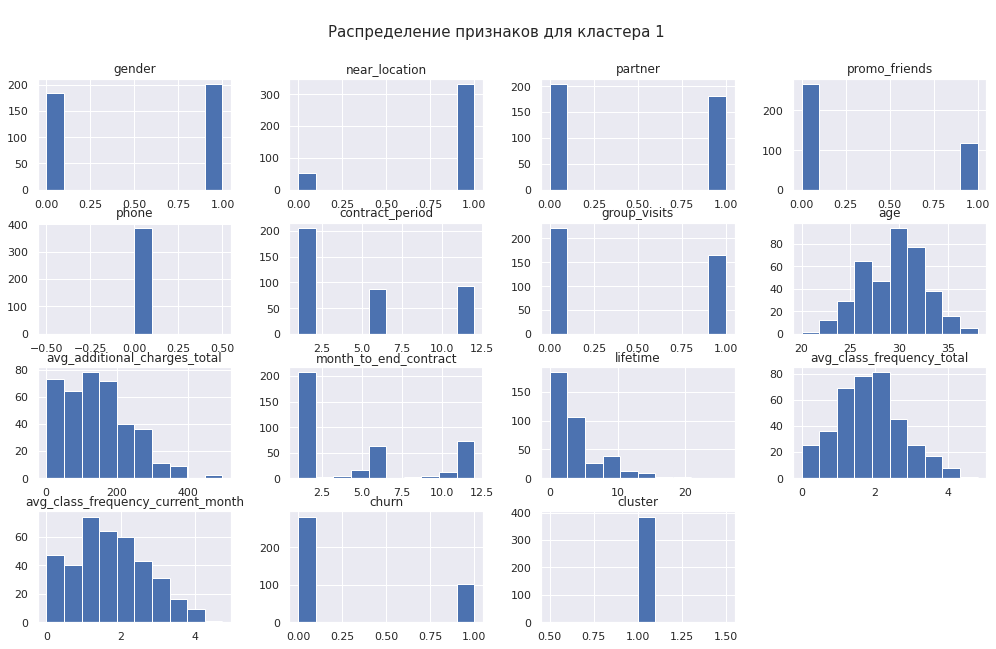

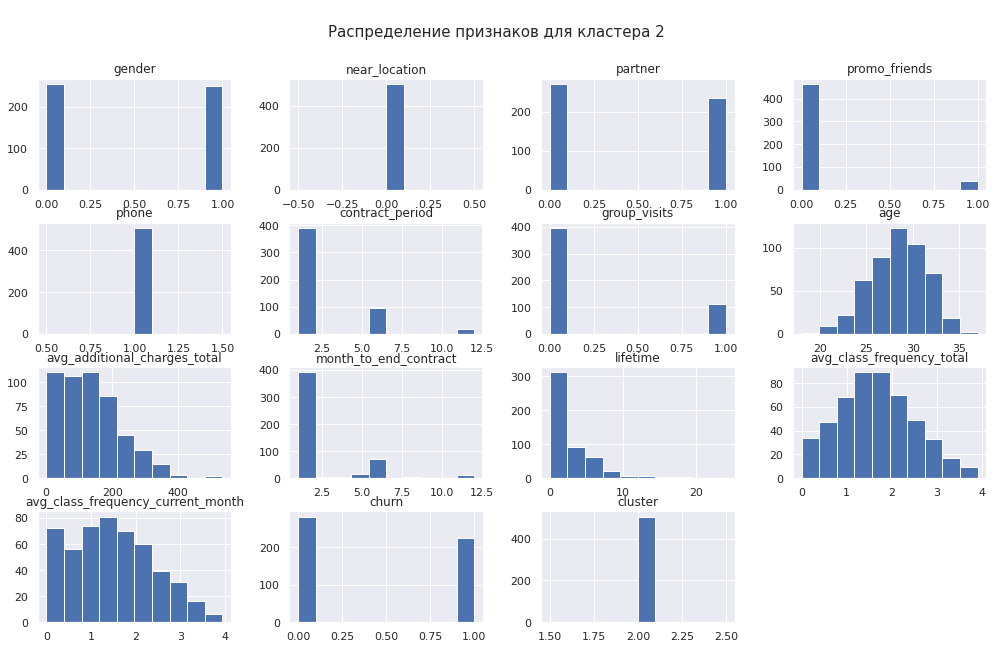

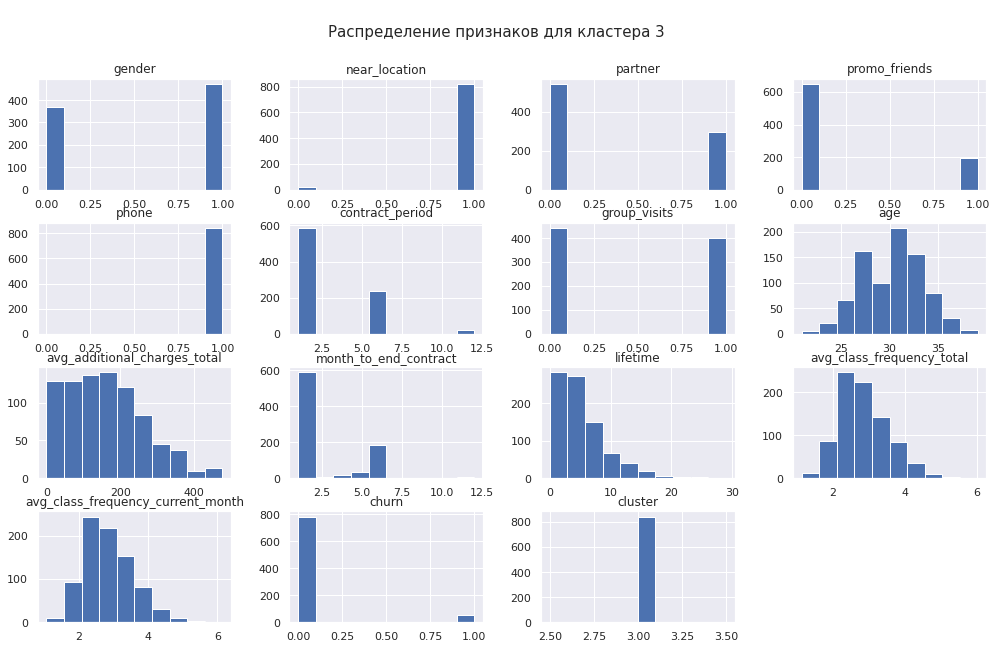

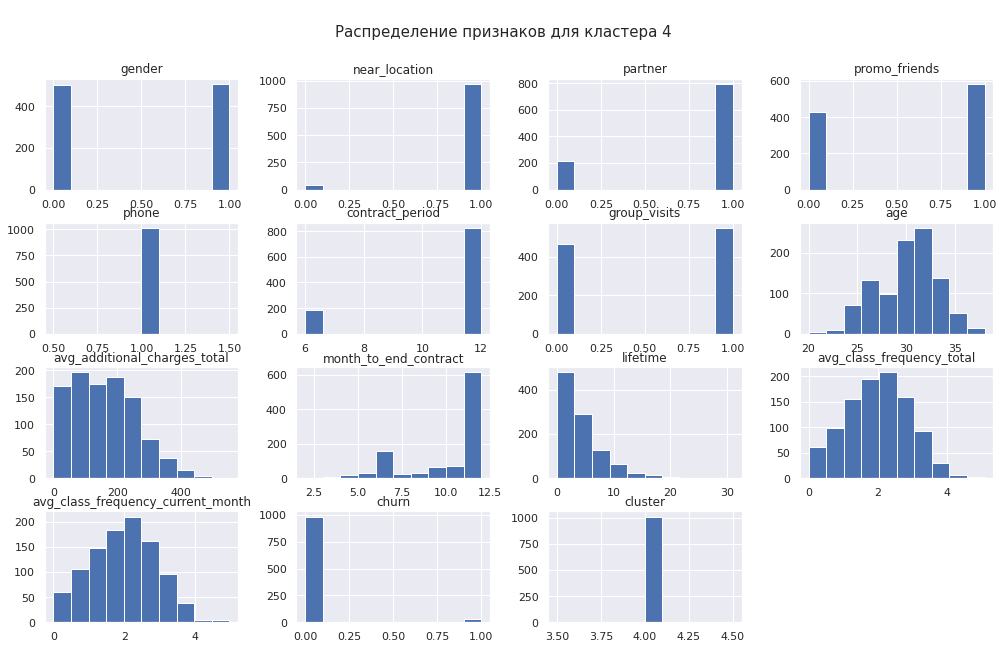

In [14]:
for value in [0, 1, 2, 3, 4]:
    data[data['cluster']==value].hist(figsize=(17,10))
    plt.suptitle('\nРаспределение признаков для кластера {}'.format(value), fontsize = 15)
    plt.show()

**Вывод**:
Т.к. женщины в исходной таблице обозначены 1, а мужчины 0 (исходя из открытой статистики посещения фитнес-клубов, женщины намного чаще являются клиентами фитнес-клубов), то в кластере 0 больше женщин, а в кластере 1 - меньше женщин. Графики говорят, что наиболее близко к клубу живут(или работают) люди, принадлежащие к кластеру 3, а дальше - к кластеру 4; люди, принадлежащие к кластеру 3 чаще пользуются акцией "приведи друга" и являются сотрудниками компаний-партнеров клуба, а к кластеру 4- реже остальных приходят по акции или работают в компании-партнере. Люди принадлежащие к кластерам 0, 1, 3 и 4 оставляли свои номера телефонов, а принадлежащие к кластеру 2 -нет. На групповые тренировки чаще ходят люди, принадлежащие к кластеру 3, реже всех остальных- к кластеру 4. Чаще покидают клуб люди, принадлежащие к кластреам 4 и 2.

## Общий вывод и рекомендации 

В результате проведенного анадиза были сделаны следующие выводы: 

1. Клиенты клуба - люди в возрасте от 18 лет до 41 года (средний возраст клиента - 29 лет).
2. Те клиенты, кто остался чаще являются сотрудниками компании-партнёра клуба, приходят в клуб по акции "приведи друга", имеют абонемент, в среднем, на 5,7 месяцев (те, кто отошел от занятий имеют абонемент в среднем на 1,7 месяца), посещают групповые занятия, приносят больше суммарной выручки от других услуг фитнес-центра, и посещают занятия, в среднем, 2 раза в неделю. Матрица корреляций показывает сильную связь между столбцами "средняя частота посещений в неделю за все время с начала действия абонемента" и "средняя частота посещений в неделю за предыдущий месяц", что говорит о стабильности посещений(или прогулов) тренировок клиентами. Также есть связь между признаками "сотрудник организации-партнера" и участник акции "приведи друга".
3. Чаще уходят молодые люди (от 20 до 26 лет), время с момента первого обращения которых в фитнес-центр составляет 1-2 месяца, с абонементом на 1 месяц.
4. Чаще остаются клиенты, которые живут или работают неподалеку, приходящие по акции "приведи друга" и посещающие групповые занятия.
5. От пола клиента отток не зависит.

**Была построена модель прогнозирования оттока клиентов. Модель была обучена 2 методами: логистической регрессией и случайным лесом. В результате сравнения двух моделей было найдено, что в данном случае модель логистической регрессии оказалась точнее.
Была сделана кластеризация клиентов. В результате анализа было выделено 5 кластеров, по которым можно разбить клиентов:**

1. В этом кластере преимущественно женщины, от 28 до 33 лет, имеющие абонементы на 12 месяцев. Среднее количество посещений занятий за всё время действия и абонементов 1-3 раза в неделю.
2. В этом кластере больше мужчин, от 27 до 32 лет. Среднее количество посещений занятий за всё время действия и абонементов 2-3 раза в неделю.
3. В этом кластере люди от 27 до 34 лет. Распределение по полу равномерное. Среднее количество посещений занятий за всё время действия и абонементов 2-4 раза в неделю. Люди из этой группы не оставляли номера телефонов. Люди, принадлежащие к этой группе часто покидают клуб.
4. В этом кластере люди от 28 до 33 лет, имеющие абонементы на 6 месяцев. Среднее количество посещений занятий за всё время действия и абонементов до 2 раз в неделю. Они наиболее близко живут или работают к клубу, чаще пользуются акцией "приведи друга" и являются сотрудниками компаний-партнеров клуба, групповые тренировки посещают чаще.
5. В этот кластер входят люди от 18 до 28 лет, имеющие абонементы на 1 месяц. Среднее количество посещений занятий за всё время действия и абонементов 1-2 раза в неделю. Они наиболее далеко живут или работают от клуба, реже остальных приходят по акции или работают в компании-партнере, реже остальных посещают групповые тренировки. Люди, принадлежащие к этой группе наиболее часто покидают клуб.

**Рекомендации:** 
Вполне логично, что выгоднее продавать больше долгосрочных абонементов - на них отток ниже. Вполне возможно, что больше пользы будет от кластеризации при общении с сотрудниками фитнесс-центра - их менеджерами, которые общаются с клиентами, а так же с маркетологами. Также была выявлена закономерность между фактом работы в компании-партнере и участием в акции "приведи друга". На основании этого можно сформулировать рекомендацию: заключать больше соглашений с близлежащими организациями на скидки для их сотрудников. А еще люди, посещающие групповые тренировки чаще становятся постоянными клиентами, так что можно предположить, что разнообразие групповых тренировок может привлечь больше клиентов.